# 1. Обучите любую модель классификации на датасете IRIS до применения PCA и после него. Сравните качество классификации по отложенной выборке.

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
# Загрузим датасет iris из sklearn
X, y = load_iris(return_X_y=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 4), (30, 4))

In [7]:
# Функция для подсчета евклидовой метрики
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [10]:
# функция реализации метода kNN
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [9]:
# функция для вычисления точности
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [11]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма на тесте: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма на тесте: 0.967


Обучение алгортма с применением метода PCA

In [15]:
# функция для стандартизации признаков
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [16]:
# Для начала отмасштабируем выборку
X = X.astype(float)

X = standard_scale(X)

In [20]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_train.T @ X_train

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(358.6498131873026, array([ 0.53431167, -0.23418048,  0.58150881,  0.56702562]))
(103.3661758743533, array([-0.35103112, -0.93496116, -0.00419036, -0.051061  ]))
(16.358673556578378, array([-0.72203946,  0.23576275,  0.13873353,  0.63547459]))
(2.7515920827023295, array([ 0.26447535, -0.12418963, -0.80161272,  0.52158103]))


Оценим долю дисперсии, которая описывается найденными компонентами.

In [21]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[74.54380418508565, 21.48421019730148, 3.400079167732547, 0.5719064498803318]
Кумулятивная доля дисперсии по компонентам 
[ 74.54380419  96.02801438  99.42809355 100.        ]


Таким образом, первая главная компонента описывает почти 75% информации, а первые две в сумме - 96%. В то же время последняя компонента описывает всего 0.6% и может быть отброжена без страха значительных потерь в качестве нашего анализа. Мы отбросим последние две компоненты, оставив первые две.

In [22]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.53431167 -0.35103112]
 [-0.23418048 -0.93496116]
 [ 0.58150881 -0.00419036]
 [ 0.56702562 -0.051061  ]]


In [23]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)

In [28]:
Z[:10]

array([[-2.24511953, -0.56377843],
       [-2.1050644 ,  0.59741413],
       [-2.37541385,  0.25226961],
       [-2.32014474,  0.50955201],
       [-2.36376852, -0.73646978],
       [-2.01809363, -1.5664367 ],
       [-2.44028016, -0.1426062 ],
       [-2.22290188, -0.30625787],
       [-2.37486385,  1.02530763],
       [-2.20055934,  0.38867219]])

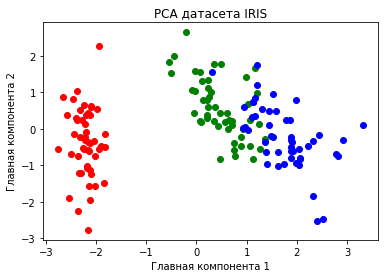

In [27]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y == i, 0], Z[y == i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

In [30]:
Z.shape

(150, 2)

Обучение модели kNN с новой матрицей Z

In [31]:
Z_train, Z_test, y_train, y_test = train_test_split(Z, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
Z_train.shape, Z_test.shape

((120, 2), (30, 2))

In [32]:
k = 5

y_pred = knn(Z_train, y_train, Z_test, k)

print(f'Точность алгоритма на тесте: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма на тесте: 0.867


Вывод: точность на тестовой выборке для модели kNN (без метода PCA) = 0.967, 
точность на тестовой выборке для модели kNN (c методом PCA) = 0.867
Дkя данного примера использование метода главных компонент оказался нецелесообразным, уменьшение размерности признаков не улучшило точность на тесте.

# 2. Напишите свою реализацию метода главных компонент посредством сингулярного разложения с использованием функции numpy.linalg.svd().

In [34]:
# Загрузим датасет iris из sklearn
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [35]:
# Отмасштабируем выборку
X = X.astype(float)

X = standard_scale(X)

In [36]:
X[:10]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ],
       [-0.53717756,  1.93979142, -1.16971425, -1.05217993],
       [-1.50652052,  0.78880759, -1.34022653, -1.18381211],
       [-1.02184904,  0.78880759, -1.2833891 , -1.3154443 ],
       [-1.74885626, -0.36217625, -1.34022653, -1.3154443 ],
       [-1.14301691,  0.09821729, -1.2833891 , -1.44707648]])

In [52]:
# Вычисление матрицы ковариации данных
cov_matrix = np.cov(X.T)

In [59]:
# найдем сингулярное разложение вектора Х

U, S, V = np.linalg.svd(cov_matrix, full_matrices=True)
U.shape, S.shape, V.shape 

((4, 4), (4,), (4, 4))

U - матрица собственные векторы матрицы 𝑋𝑇𝑋, S -матрица собственных значений (в порядке убывания) матрицы 𝑋𝑇𝑋 

In [61]:
# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(S[i]), U[:, i]) for i in range(len(S))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(2.938085050199995, array([-0.52106591,  0.26934744, -0.5804131 , -0.56485654]))
(0.9201649041624876, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(0.14774182104494799, array([ 0.71956635, -0.24438178, -0.14212637, -0.63427274]))
(0.020853862176462432, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


Оценим долю дисперсии, которая описывается найденными компонентами.

In [62]:
eig_sum = sum(S)
var_exp = [(i / eig_sum) * 100 for i in sorted(S, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329987, 22.850761786701774, 3.6689218892828745, 0.5178709107154837]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


Для сравнения полученных результатов с методом PCA, отбросим два последних признака и отсавим два первых, которые описывают почти 96% от общей информации. 

In [63]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[-0.52106591 -0.37741762]
 [ 0.26934744 -0.92329566]
 [-0.5804131  -0.02449161]
 [-0.56485654 -0.06694199]]


In [64]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)

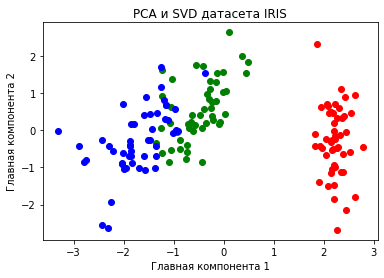

In [68]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y == i, 0], Z[y == i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA и SVD датасета IRIS')
plt.show()

In [66]:
Z_train, Z_test, y_train, y_test = train_test_split(Z, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
Z_train.shape, Z_test.shape

((120, 2), (30, 2))

In [67]:
k = 5

y_pred = knn(Z_train, y_train, Z_test, k)

print(f'Точность алгоритма на тесте: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма на тесте: 0.867


Вывод: точечный график "PCA и SVD датасета IRIS" получился зеркальным отображением графика "PCA датасета IRIS". Точности моделей обученных на двух вариантах оказались одинаковыми.